<a href="https://colab.research.google.com/github/Akitsuyoshi/recaptch_breaker/blob/main/recaptch_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import necessary libraries

In [4]:
import os
import warnings
import zipfile

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 8.2 MB/s 
     |████████████████████████████████| 5.5 MB 28.9 MB/s 
     |████████████████████████████████| 1.3 MB 49.8 MB/s 
     |████████████████████████████████| 441 kB 52.6 MB/s 
     |████████████████████████████████| 1.6 MB 47.0 MB/s 
     |████████████████████████████████| 212 kB 49.5 MB/s 
     |████████████████████████████████| 163 kB 56.8 MB/s 
     |████████████████████████████████| 95 kB 5.2 MB/s 
     |████████████████████████████████| 115 kB 51.1 MB/s 
     |████████████████████████████████| 127 kB 48.2 MB/s 
     |████████████████████████████████| 115 kB 44.4 MB/s 
     |████████████████████████████████| 7.6 MB 34.0 MB/s 
Mounted at /content/gdrive


In [3]:
from fastbook import *
from fastai.vision.widgets import *

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/images.zip', 'r') as zip:
  zip.printdir()
  print("extracting all the files now")
  zip.extractall()
  print('Done')

In [40]:
def getting_img_data():
  def sort_dict(unsorted_dict):
    return dict(sorted(unsorted_dict.items(), key=lambda item: item[1], reverse=True))

  images_data = {}
  for i, j, k in os.walk('images'):
    if len(k) > 0:
      images_data[k[0].split(' ')[0]] = len(k)
  
  return sort_dict(images_data)
  
images_data = getting_img_data()

In [48]:
len(images_data.keys()), images_data

(12,
 {'Car': 3558,
  'Other': 1340,
  'Cross': 1240,
  'Bus': 1209,
  'Hydrant': 952,
  'Palm': 911,
  'Tlight': 791,
  'Bicycle': 780,
  'Bridge': 533,
  'Stair': 211,
  'Chimney': 124,
  'Motorcycle': 81})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


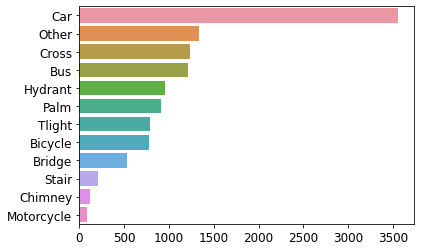

In [42]:
sns.barplot(list(images_data.values()), list(images_data.keys()))

In [46]:
path = Path('images')
get_image_files(path)

(#11730) [Path('images/Bridge/Bridge (175).png'),Path('images/Bridge/Bridge (230).png'),Path('images/Bridge/Bridge (315).png'),Path('images/Bridge/Bridge (464).png'),Path('images/Bridge/Bridge (481).png'),Path('images/Bridge/Bridge (104).png'),Path('images/Bridge/Bridge (60).png'),Path('images/Bridge/Bridge (130).png'),Path('images/Bridge/Bridge (105).png'),Path('images/Bridge/Bridge (424).png')...]

In [62]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.8),
    batch_tfms=aug_transforms()
)
dls = dblock.dataloaders(path)
dls.loss_func

FlattenedLoss of CrossEntropyLoss()

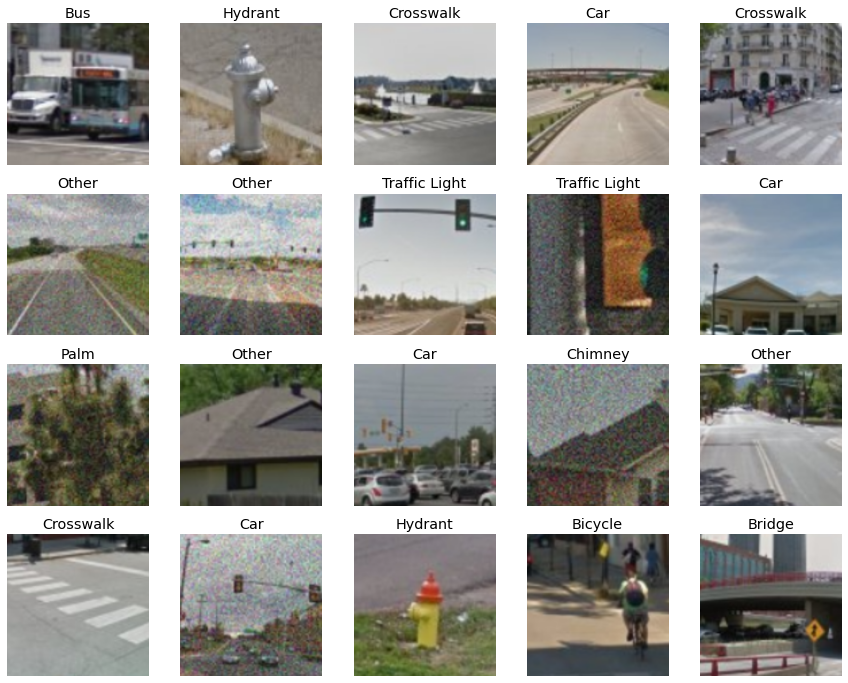

In [63]:
dls.valid.show_batch(max_n=20, nrows=4)

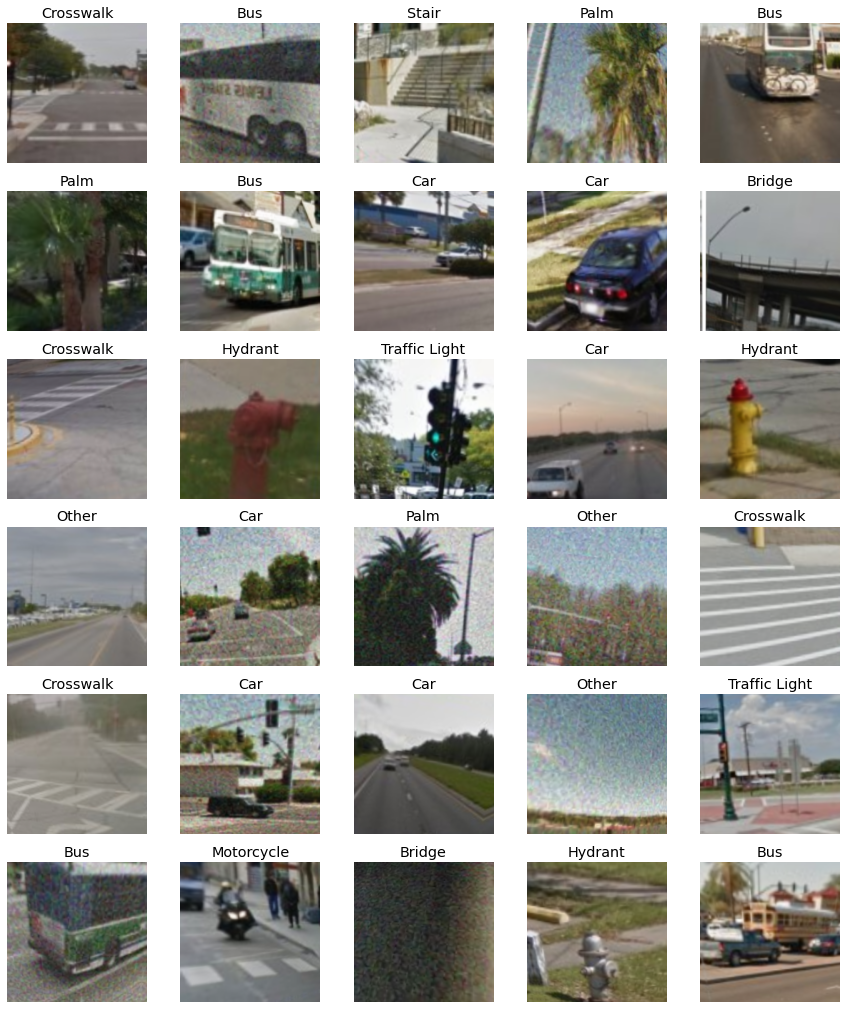

In [64]:
dls.train.show_batch(max_n=30, nrows=6)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=accuracy).to_fp16()
learn.lr_find()

In [ ]:
lr = 0
learn.fine_tune(4, lr)

In [ ]:
learn.recorder.plot_loss()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(3, nrows=1)

In [ ]:
learn.export('baseline_model.pkl')